In [2]:
!pip install -q pyspark

# TP2 et 3 
## Very Large Graph
### Habib Adoum Mandazou Joseph Durand Reyane En-nabty

In [3]:
import networkx as nx
import multiprocessing
import time
import matplotlib.pyplot as plt

from pyspark import SparkContext
from itertools import combinations
from concurrent.futures import ProcessPoolExecutor

In [4]:
def afficher_graphe_avec_clique_maximale(G, clique_max, method_name):
    pos = nx.spring_layout(G)
    plt.figure(figsize=(8, 6))
    nx.draw(G, pos, with_labels=True, node_color='lightblue', node_size=500, font_size=10)

    nx.draw(G.subgraph(clique_max), pos, node_color="red", node_size=500, font_size=10)

    plt.title(f"{method_name} avec clique maximale en rouge")
    plt.show()

In [5]:
# On utilise le même graphe pour toutes les implémentations
n = 20 # Pour les grandes valeurs de n, il faut enlever la méthode naïve du benchmark car trop lente
p = 0.3

G = nx.erdos_renyi_graph(n, p)

## 1. Approche naïve :

In [6]:
def est_clique(G, S):
    # Vérifier si chaque paire de sommets dans S est reliée par une arête dans G
    for v, w in combinations(S, 2):
        if not G.has_edge(v, w):
            return False
    return True

def recherche_clique_naive_parallel_subtask(G, combination_size):
    # Initialiser la taille maximale de la clique et la clique maximale
    taille_max_clique = 0
    clique_max = set()

    # Parcourir toutes les combinaisons de sommets de la taille donnée
    for S in combinations(G.nodes, combination_size):
        # Vérifier si la combinaison forme une clique et si elle est plus grande que la clique maximale connue
        if est_clique(G, S) and len(S) > taille_max_clique:
            taille_max_clique = len(S)
            clique_max = set(S)

    # Renvoyer la clique maximale trouvée
    return clique_max

def recherche_clique_naive_parallel(G):
    # Nombre de sommets dans le graphe
    n = len(G)

    # Déterminer le nombre maximal de travailleurs en parallèle
    max_workers = multiprocessing.cpu_count()

    # Utiliser un pool de processus pour la parallélisation
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Soumettre des tâches parallèles pour différentes tailles de combinaison
        futures = [executor.submit(recherche_clique_naive_parallel_subtask, G, i) for i in range(1, n + 1)]

        # Récupérer les résultats des tâches parallèles
        result_cliques = [future.result() for future in futures]

    # Convertir la liste de cliques en liste de listes
    return list(result_cliques)


## 2. Algorithme de Bron-Kerbosch sans pivot parallélisé


In [7]:
def bron_kerbosch1(R, P, X, graph):
    # Cas de base : si P et X sont vides, renvoyer la clique formée par R
    if not P and not X:
        return [R]

    # Liste pour stocker les cliques
    cliques = []

    # Parcourir les sommets v dans l'ensemble P
    for v in list(P):
        # Ensemble des voisins de v
        N_v = set(graph.neighbors(v))

        # Appel récursif avec les ensembles mis à jour
        cliques += bron_kerbosch1(R.union({v}), P.intersection(N_v), X.intersection(N_v), graph)

        # Mettre à jour P et X
        P.remove(v)
        X.add(v)

    # Renvoyer la liste des cliques
    return cliques

def bron_kerbosch1_parallel(graph, max_workers=None):
    # Liste pour stocker les cliques
    cliques = []

    # Utiliser un pool de processus pour la parallélisation
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Liste pour stocker les futures des tâches parallèles
        futures = []

        # Parcourir tous les nœuds du graphe
        for v in graph.nodes():
            # Initialiser les ensembles R, P et X
            P = set(graph.neighbors(v))
            X = set()
            R = {v}

            # Soumettre une tâche parallèle pour trouver les cliques maximales
            future = executor.submit(bron_kerbosch1, R, P, X, graph)
            futures.append(future)

        # Attendre que toutes les tâches parallèles soient terminées
        for future in futures:
            # Récupérer les résultats des tâches parallèles
            cliques += future.result()

    # Supprimer les doublons si nécessaire
    unique_cliques = [list(x) for x in set(tuple(x) for x in cliques)]

    # Renvoyer les cliques maximales uniques
    return unique_cliques

def find_maximal_cliques_bron_kerbosch1_parallel(graph):
    # Déterminer le nombre maximal de travailleurs en parallèle
    max_workers = multiprocessing.cpu_count()

    # Appeler la fonction bron_kerbosch1_parallel avec le nombre maximal de travailleurs
    return bron_kerbosch1_parallel(graph, max_workers=max_workers)


## 3. Algorithme de Bron-Kerbosch avec pivot parallélisé

In [8]:
def bron_kerbosch2(R, P, X, graph):
    # Cas de base : si P et X sont vides, renvoyer la clique formée par R
    if not P and not X:
        return [R]

    # Liste pour stocker les cliques
    cliques = []

    # Choisir un sommet u de l'union de P et X
    u = next(iter(P.union(X)))

    # Ensemble des voisins de u
    N_u = set(graph.neighbors(u))

    # Parcourir les voisins v de P - N(u)
    for v in list(P.difference(N_u)):
        # Ensemble des voisins de v
        N_v = set(graph.neighbors(v))

        # Appel récursif avec les ensembles mis à jour
        cliques += bron_kerbosch2(R.union({v}), P.intersection(N_v), X.intersection(N_v), graph)

        # Mettre à jour P et X
        P.remove(v)
        X.add(v)

    # Renvoyer la liste des cliques
    return cliques

def bron_kerbosch2_parallel(graph, max_workers=None):
    # Liste pour stocker les cliques
    cliques = []

    # Utiliser un pool de processus pour la parallélisation
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Liste pour stocker les futures des tâches parallèles
        futures = []

        # Parcourir tous les nœuds du graphe
        for v in graph.nodes():
            # Initialiser les ensembles R, P et X
            P = set(graph.neighbors(v))
            X = set()
            R = {v}

            # Soumettre une tâche parallèle pour trouver les cliques maximales
            future = executor.submit(bron_kerbosch2, R, P, X, graph)
            futures.append(future)

        # Attendre que toutes les tâches parallèles soient terminées
        for future in futures:
            # Récupérer les résultats des tâches parallèles
            cliques += future.result()

    # Supprimer les doublons si nécessaire
    unique_cliques = [list(x) for x in set(tuple(x) for x in cliques)]

    # Renvoyer les cliques maximales uniques
    return unique_cliques

def find_maximal_cliques_bron_kerbosch2_parallel(graph):
    # Déterminer le nombre maximal de travailleurs en parallèle
    max_workers = multiprocessing.cpu_count()

    # Appeler la fonction bron_kerbosch2_parallel avec le nombre maximal de travailleurs
    return bron_kerbosch2_parallel(graph, max_workers=max_workers)


## 4. Algorithme de Bron-Kerbosch avec pivot et dégénérescence parallélisé

In [9]:
def degeneracy_ordering(graph):
    # Liste pour stocker l'ordre de dégénérescence des nœuds
    ordering = []

    # Dictionnaire pour stocker les degrés de chaque nœud
    degrees = {v: len(list(graph.neighbors(v))) for v in graph.nodes()}

    # Liste de listes où la i-ème liste contient les nœuds de degré i
    degree_lists = [[] for _ in range(len(graph) + 1)]

    # Remplissage des listes de degrés avec les nœuds correspondants
    for v, d in degrees.items():
        degree_lists[d].append(v)

    # Algorithme de dégénérescence
    while degree_lists:
        i = 0
        # Trouver le premier indice non vide
        while i < len(degree_lists) and not degree_lists[i]:
            i += 1
        # Si tous les indices sont vides, sortir de la boucle
        if i == len(degree_lists):
            break

        # Retirer le nœud du degré le plus bas de la liste
        v = degree_lists[i].pop()

        # Ajouter le nœud à l'ordre
        ordering.append(v)

        # Mettre à jour les listes de degrés pour les voisins du nœud retiré
        for w in list(graph.neighbors(v)):
            if w not in ordering:
                d = degrees[w]
                degree_lists[d].remove(w)
                degree_lists[d-1].append(w)
                degrees[w] -= 1

    # Renvoyer l'ordre de dégénérescence
    return ordering


def bron_kerbosch3_parallel(graph):
    # Obtenir l'ordre de dégénérescence des nœuds
    ordering = degeneracy_ordering(graph)

    # Liste pour stocker les cliques maximales
    cliques = []

    # Déterminer le nombre maximal de travailleurs en parallèle
    max_workers = multiprocessing.cpu_count()

    # Utiliser un pool de processus pour la parallélisation
    with ProcessPoolExecutor(max_workers=max_workers) as executor:
        # Liste pour stocker les futures des tâches parallèles
        futures = []

        # Parcourir les nœuds dans l'ordre de dégénérescence
        for v in ordering:

            # Soumettre une tâche parallèle pour trouver les cliques maximales
            future = executor.submit(bron_kerbosch2_parallel, graph, max_workers=max_workers)

            # Ajouter la future à la liste
            futures.append(future)

        # Attendre que toutes les tâches parallèles soient terminées
        for future in futures:
            # Récupérer les résultats des tâches parallèles
            cliques += future.result()

    # Supprimer les doublons si nécessaire
    unique_cliques = [list(x) for x in set(tuple(x) for x in cliques)]

    # Renvoyer les cliques maximales uniques
    return unique_cliques


In [10]:
# Test de chaque algorithme et mesure du temps d'exécution
start_time = time.time()
maximal_cliques_simple = recherche_clique_naive_parallel(G)
clique_max_simple = max(maximal_cliques_simple, key=len)
print(f"Nombre de cliques maximales trouvéesl: {len(maximal_cliques_simple)}")
print(f"Toutes les cliques maximales (approche naïve) : {maximal_cliques_simple}")
print(f"Clique maximale (Simple/Naïf): {clique_max_simple}")
print(f"Temps d'exécution (Simple/Naïf): {time.time() - start_time} secondes")

start_time = time.time()
maximal_cliques_bron_kerbosch1 = find_maximal_cliques_bron_kerbosch1_parallel(G)
clique_max_bron_kerbosch1 = max(maximal_cliques_bron_kerbosch1, key=len)
print(f"Nombre de cliques maximales trouvéesl: {len(maximal_cliques_bron_kerbosch1)}")
print(f"Toutes les cliques maximales (Bron-Kerbosch sans pivot) : {maximal_cliques_bron_kerbosch1}")
print(f"Clique maximale (Bron-Kerbosch sans pivot): {clique_max_bron_kerbosch1}")
print(f"Temps d'exécution (Bron-Kerbosch sans pivot): {time.time() - start_time} secondes")

start_time = time.time()
maximal_cliques_bron_kerbosch2 = find_maximal_cliques_bron_kerbosch2_parallel(G)
clique_max_bron_kerbosch2 = max(maximal_cliques_bron_kerbosch2, key=len)
print(f"Nombre de cliques maximales trouvéesl: {len(maximal_cliques_bron_kerbosch2)}")
print(f"Toutes les cliques maximales (Bron-Kerbosch avec pivot) : {maximal_cliques_bron_kerbosch2}")
print(f"Clique maximale (Bron-Kerbosch avec pivot): {clique_max_bron_kerbosch2}")
print(f"Temps d'exécution (Bron-Kerbosch avec pivot): {time.time() - start_time} secondes")

start_time = time.time()
maximal_cliques_bron_kerbosch3 = bron_kerbosch3_parallel(G)
clique_max_bron_kerbosch3 = max(maximal_cliques_bron_kerbosch3, key=len)
print(f"Nombre de cliques maximales trouvéesl: {len(maximal_cliques_bron_kerbosch3)}")
print(f"Toutes les cliques maximales (Bron-Kerbosch avec pivot et dégénérescence) : {maximal_cliques_bron_kerbosch3}")
print(f"Clique maximale (Bron-Kerbosch avec pivot et dégénérescence): {clique_max_bron_kerbosch3}")
print(f"Temps d'exécution (Bron-Kerbosch avec pivot et dégénérescence): {time.time() - start_time} secondes")

Nombre de cliques maximales trouvéesl: 20
Toutes les cliques maximales (approche naïve) : [{0}, {0, 1}, {0, 1, 14}, {16, 4, 14, 15}, set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set(), set()]
Clique maximale (Simple/Naïf): {16, 4, 14, 15}
Temps d'exécution (Simple/Naïf): 0.6057999134063721 secondes
Nombre de cliques maximales trouvéesl: 38
Toutes les cliques maximales (Bron-Kerbosch sans pivot) : [[1, 19, 12], [18, 10, 12], [6, 15], [16, 11, 4], [2, 19, 12], [16, 4, 14, 15], [17, 13, 15], [9, 2], [3, 13], [8, 6], [1, 6], [9, 11], [1, 13, 17], [0, 10, 14], [17, 18, 1], [9, 10], [0, 1, 14], [10, 4, 14], [10, 5], [5, 15], [9, 13], [1, 5], [1, 18, 12], [16, 17, 15], [17, 13, 1], [16, 17, 18], [4, 7], [3, 5], [3, 19, 12], [0, 3], [10, 18, 12], [8, 16], [19, 3, 12], [16, 2], [1, 7], [2, 6], [16, 8], [1, 18, 17]]
Clique maximale (Bron-Kerbosch sans pivot): [16, 4, 14, 15]
Temps d'exécution (Bron-Kerbosch sans pivot): 0.19790291786193848 sec

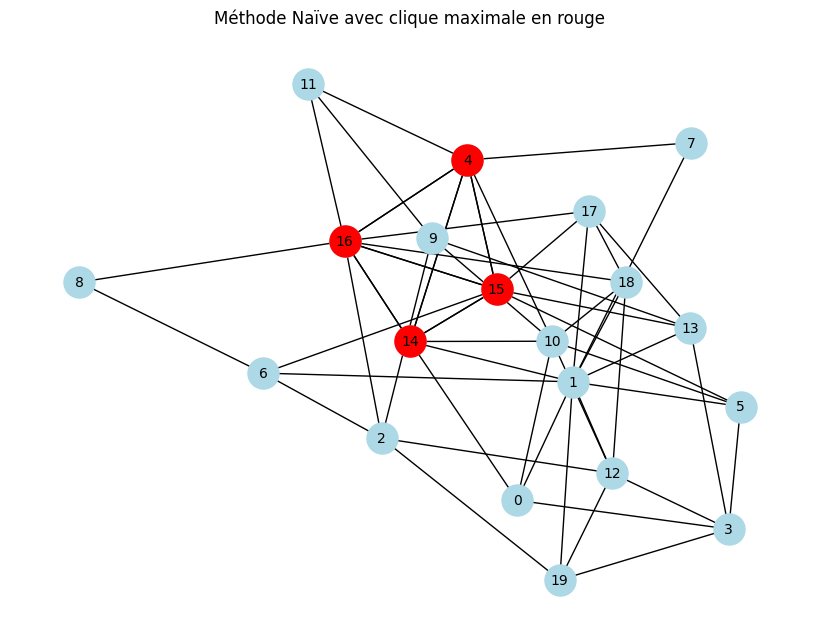

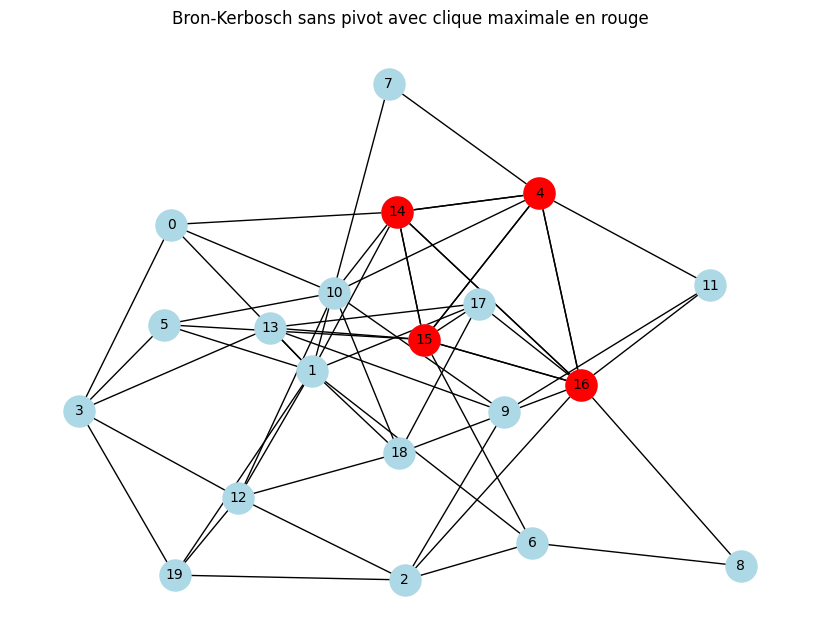

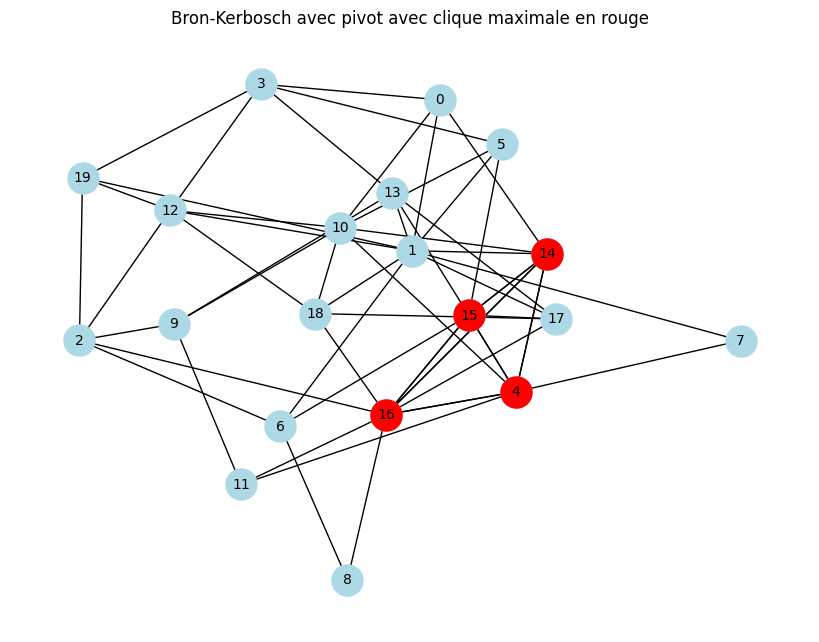

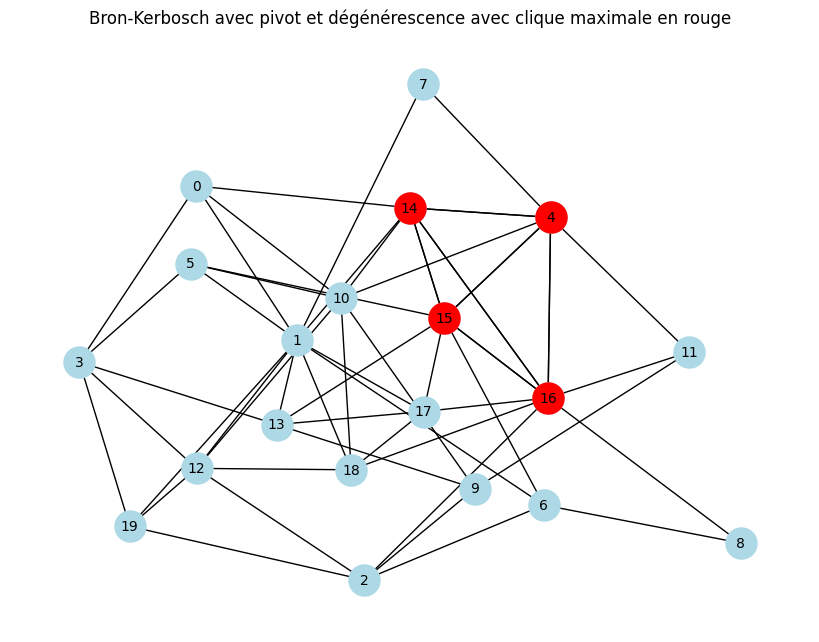

In [11]:
afficher_graphe_avec_clique_maximale(G, clique_max_simple, "Méthode Naïve")
afficher_graphe_avec_clique_maximale(G, clique_max_bron_kerbosch1, "Bron-Kerbosch sans pivot")
afficher_graphe_avec_clique_maximale(G, clique_max_bron_kerbosch2, "Bron-Kerbosch avec pivot")
afficher_graphe_avec_clique_maximale(G, clique_max_bron_kerbosch3, "Bron-Kerbosch avec pivot et dégénérescence")

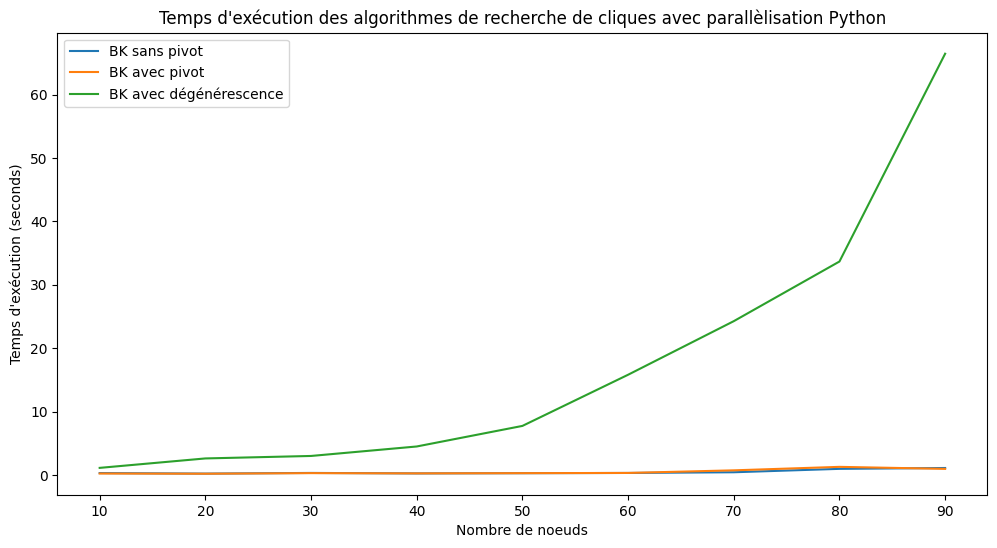

In [12]:
graph_sizes = [i for i in range(10, 100, 10)]

bk_without_times = []
bk_with_times = []
bk_with_degeneracy_times = []

for n in graph_sizes:
    graph = nx.erdos_renyi_graph(n, 0.5)

    start_time = time.time()
    find_maximal_cliques_bron_kerbosch1_parallel(graph)
    bk_without_times.append(time.time() - start_time)

    start_time = time.time()
    find_maximal_cliques_bron_kerbosch2_parallel(graph)
    bk_with_times.append(time.time() - start_time)

    start_time = time.time()
    bron_kerbosch3_parallel(graph)
    bk_with_degeneracy_times.append(time.time() - start_time)

plt.figure(figsize=(12, 6))
plt.plot(graph_sizes, bk_without_times, label='BK sans pivot')
plt.plot(graph_sizes, bk_with_times, label='BK avec pivot')
plt.plot(graph_sizes, bk_with_degeneracy_times, label='BK avec dégénérescence')
plt.xlabel('Nombre de noeuds')
plt.ylabel('Temps d\'exécution (seconds)')
plt.title('Temps d\'exécution des algorithmes de recherche de cliques avec parallèlisation Python')
plt.legend()
plt.show()

# Pyspark

## 1. Naïve

In [13]:
def est_clique(G, S):
    for v, w in combinations(S, 2):
        if w not in G[v]:
            return False
    return True

def recherche_clique_naive_spark(G):
    sc = SparkContext.getOrCreate()

    n = len(G.nodes())
    node_combinations = sc.parallelize(range(1, n + 1)).flatMap(lambda x: combinations(G.nodes(), x))
    cliques = node_combinations.filter(lambda S: est_clique(G, S))

    largest_clique = cliques.max(key=len)
    return largest_clique

## 2. Algorithme de Bron-Kerbosch sans pivot

In [14]:
def bron_kerbosch1(R, P, X, graph, cliques):
    if not P and not X:
        cliques.append(R)
        return
    for v in list(P):
        N_v = set(graph.neighbors(v))
        bron_kerbosch1(R.union({v}), P.intersection(N_v), X.intersection(N_v), graph, cliques)
        P.remove(v)
        X.add(v)

def find_cliques_for_vertex(v, graph):
    cliques = []
    N_v = set(graph.neighbors(v))
    bron_kerbosch1({v}, N_v, set(), graph, cliques)
    return cliques

def find_maximal_cliques_bron_kerbosch1_spark(graph):
    sc = SparkContext.getOrCreate()
    vertices = sc.parallelize(graph.nodes())
    cliques = vertices.flatMap(lambda v: find_cliques_for_vertex(v, graph))
    maximal_cliques = cliques.collect()
    sc.stop()

    unique_cliques = [list(x) for x in set(tuple(x) for x in maximal_cliques)]
    return unique_cliques

## 3. Algorithme de Bron-Kerbosch avec pivot

In [15]:
def bron_kerbosch2(R, P, X, graph, cliques):
    if not P and not X:
        cliques.append(R)
        return
    u = next(iter(P.union(X)))
    N_u = set(graph.neighbors(u))
    for v in list(P.difference(N_u)):
        N_v = set(graph.neighbors(v))
        bron_kerbosch2(R.union({v}), P.intersection(N_v), X.intersection(N_v), graph, cliques)
        P.remove(v)
        X.add(v)

def find_cliques_for_vertex2(v, graph):
    cliques = []
    N_v = set(graph.neighbors(v))
    bron_kerbosch2({v}, N_v, set(), graph, cliques)
    return cliques

def find_maximal_cliques_bron_kerbosch2_spark(graph):
    sc = SparkContext.getOrCreate()
    vertices = sc.parallelize(graph.nodes())
    cliques = vertices.flatMap(lambda v: find_cliques_for_vertex2(v, graph))
    maximal_cliques = cliques.collect()
    sc.stop()

    # On enlève les doublons
    unique_cliques = [list(x) for x in set(tuple(x) for x in maximal_cliques)]
    return unique_cliques

## 4. Algorithme de Bron-Kerbosch avec pivot et dégénérescence

In [16]:
def bron_kerbosch3_spark(graph):
    sc = SparkContext.getOrCreate()

    serialized_graph = nx.node_link_data(graph)
    broadcast_graph = sc.broadcast(serialized_graph)
    ordering = degeneracy_ordering(graph)
    vertices = sc.parallelize(ordering)

    cliques_rdd = vertices.flatMap(lambda v: find_cliques_for_vertex2(v, nx.node_link_graph(broadcast_graph.value)))
    all_cliques = cliques_rdd.collect()

    sc.stop()

    unique_cliques = [list(x) for x in set(tuple(x) for x in all_cliques)]
    return unique_cliques

In [17]:
# Test de chaque algorithme et mesure du temps d'exécution
start_time = time.time()
clique_max_simple = recherche_clique_naive_spark(G)
print(f"Clique maximale (Simple/Naïf): {clique_max_simple}")
print(f"Temps d'exécution (Simple/Naïf): {time.time() - start_time} secondes")

start_time = time.time()
maximal_cliques_bron_kerbosch1 = find_maximal_cliques_bron_kerbosch1_spark(G)
clique_max_bron_kerbosch1 = max(maximal_cliques_bron_kerbosch1, key=len)
print(f"Nombre de cliques maximales trouvéesl: {len(maximal_cliques_bron_kerbosch1)}")
print(f"Toutes les cliques maximales (Bron-Kerbosch sans pivot) : {maximal_cliques_bron_kerbosch1}")
print(f"Clique maximale (Bron-Kerbosch sans pivot): {clique_max_bron_kerbosch1}")
print(f"Temps d'exécution (Bron-Kerbosch sans pivot): {time.time() - start_time} secondes")

start_time = time.time()
maximal_cliques_bron_kerbosch2 = find_maximal_cliques_bron_kerbosch2_spark(G)
clique_max_bron_kerbosch2 = max(maximal_cliques_bron_kerbosch2, key=len)
print(f"Nombre de cliques maximales trouvéesl: {len(maximal_cliques_bron_kerbosch2)}")
print(f"Toutes les cliques maximales (Bron-Kerbosch avec pivot) : {maximal_cliques_bron_kerbosch2}")
print(f"Clique maximale (Bron-Kerbosch avec pivot): {clique_max_bron_kerbosch2}")
print(f"Temps d'exécution (Bron-Kerbosch avec pivot): {time.time() - start_time} secondes")

start_time = time.time()
maximal_cliques_bron_kerbosch3 = bron_kerbosch3_spark(G)
clique_max_bron_kerbosch3 = max(maximal_cliques_bron_kerbosch3, key=len)
print(f"Nombre de cliques maximales trouvéesl: {len(maximal_cliques_bron_kerbosch3)}")
print(f"Toutes les cliques maximales (Bron-Kerbosch avec pivot et dégénérescence) : {maximal_cliques_bron_kerbosch3}")
print(f"Clique maximale (Bron-Kerbosch avec pivot et dégénérescence): {clique_max_bron_kerbosch3}")
print(f"Temps d'exécution (Bron-Kerbosch avec pivot et dégénérescence): {time.time() - start_time} secondes")

23/11/28 14:22:35 WARN Utils: Your hostname, DESKTOP-VH0FEH5 resolves to a loopback address: 127.0.1.1; using 10.40.245.25 instead (on interface wifi0)
23/11/28 14:22:35 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/11/28 14:22:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Clique maximale (Simple/Naïf): (4, 14, 15, 16)
Temps d'exécution (Simple/Naïf): 21.199161767959595 secondes
Nombre de cliques maximales trouvéesl: 38
Toutes les cliques maximales (Bron-Kerbosch sans pivot) : [[1, 19, 12], [18, 10, 12], [6, 15], [16, 11, 4], [2, 19, 12], [16, 4, 14, 15], [17, 13, 15], [9, 2], [3, 13], [8, 6], [1, 6], [9, 11], [1, 13, 17], [0, 10, 14], [17, 18, 1], [9, 10], [0, 1, 14], [10, 4, 14], [10, 5], [5, 15], [9, 13], [1, 5], [1, 18, 12], [16, 17, 15], [17, 13, 1], [16, 17, 18], [4, 7], [3, 5], [3, 19, 12], [0, 3], [10, 18, 12], [8, 16], [19, 3, 12], [16, 2], [1, 7], [2, 6], [16, 8], [1, 18, 17]]
Clique maximale (Bron-Kerbosch sans pivot): [16, 4, 14, 15]
Temps d'exécution (Bron-Kerbosch sans pivot): 1.4202237129211426 secondes


Nombre de cliques maximales trouvéesl: 38
Toutes les cliques maximales (Bron-Kerbosch avec pivot) : [[1, 19, 12], [18, 10, 12], [6, 15], [16, 11, 4], [2, 19, 12], [16, 4, 14, 15], [17, 13, 15], [9, 2], [3, 13], [8, 6], [1, 6], [9, 11], [1, 13, 17], [0, 10, 14], [17, 18, 1], [9, 10], [0, 1, 14], [10, 4, 14], [10, 5], [5, 15], [9, 13], [1, 5], [1, 18, 12], [16, 17, 15], [17, 13, 1], [16, 17, 18], [4, 7], [3, 5], [3, 19, 12], [0, 3], [10, 18, 12], [8, 16], [19, 3, 12], [16, 2], [1, 7], [2, 6], [16, 8], [1, 18, 17]]
Clique maximale (Bron-Kerbosch avec pivot): [16, 4, 14, 15]
Temps d'exécution (Bron-Kerbosch avec pivot): 3.5105090141296387 secondes


Nombre de cliques maximales trouvéesl: 38
Toutes les cliques maximales (Bron-Kerbosch avec pivot et dégénérescence) : [[1, 19, 12], [18, 10, 12], [6, 15], [16, 11, 4], [2, 19, 12], [16, 4, 14, 15], [17, 13, 15], [9, 2], [3, 13], [8, 6], [9, 11], [1, 6], [1, 13, 17], [0, 10, 14], [17, 18, 1], [9, 10], [5, 15], [10, 5], [0, 1, 14], [9, 13], [10, 4, 14], [1, 5], [1, 18, 12], [16, 17, 15], [17, 13, 1], [16, 17, 18], [4, 7], [3, 5], [10, 18, 12], [3, 19, 12], [0, 3], [8, 16], [19, 3, 12], [16, 2], [1, 7], [2, 6], [16, 8], [1, 18, 17]]
Clique maximale (Bron-Kerbosch avec pivot et dégénérescence): [16, 4, 14, 15]
Temps d'exécution (Bron-Kerbosch avec pivot et dégénérescence): 3.553577423095703 secondes


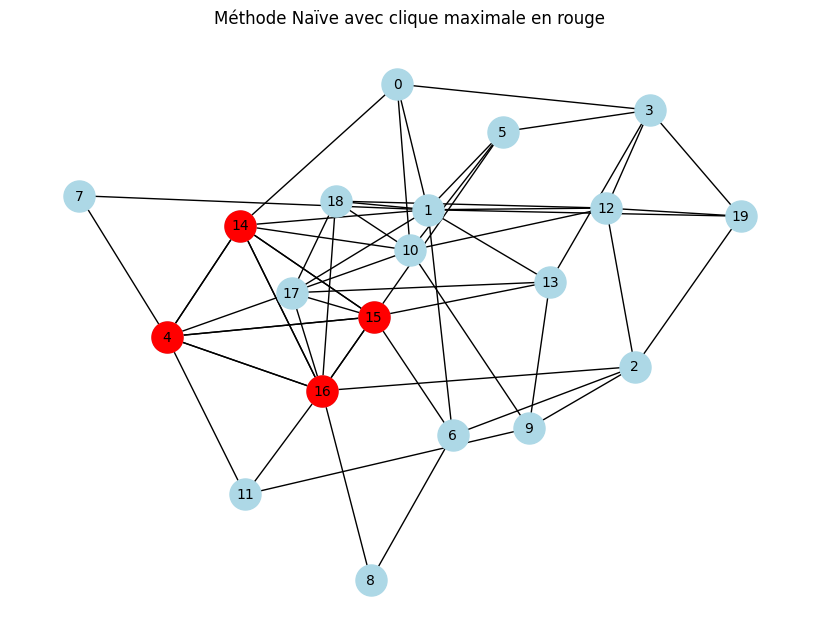

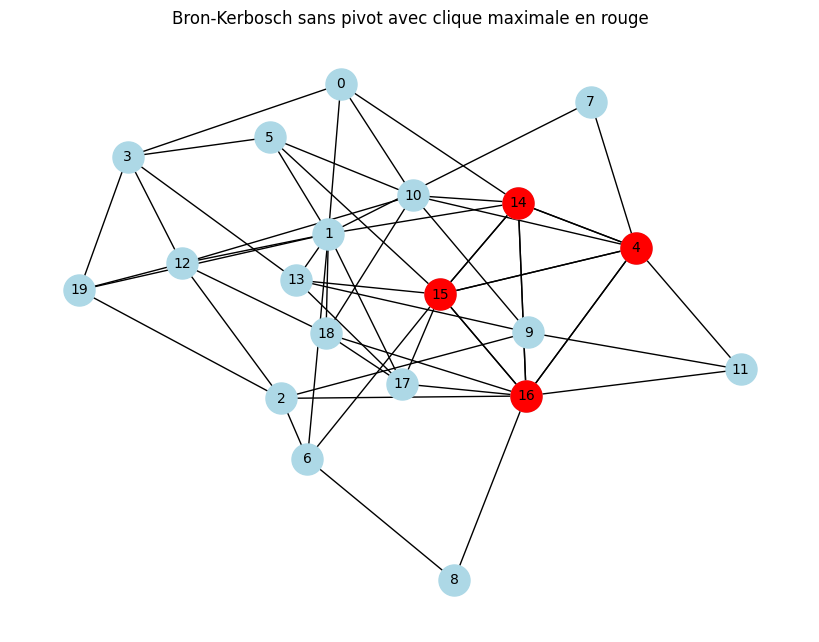

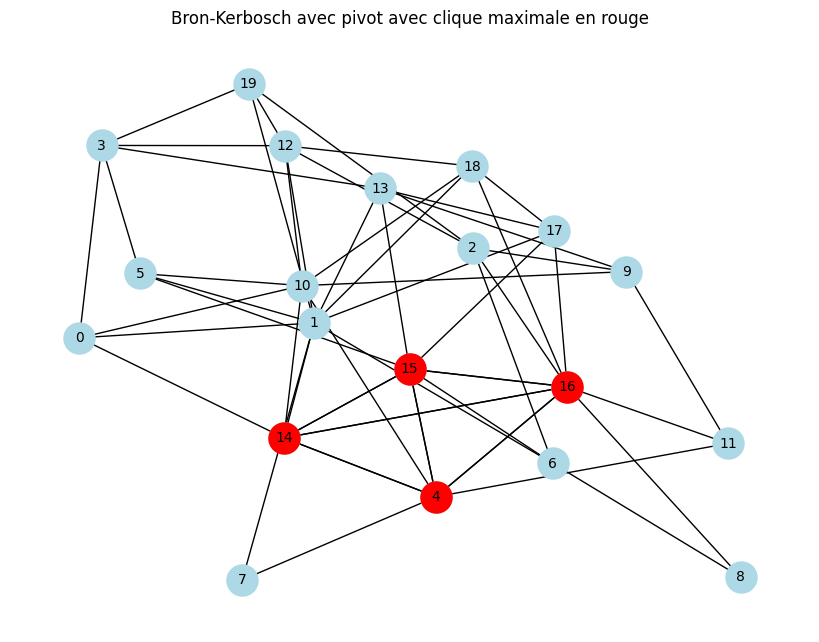

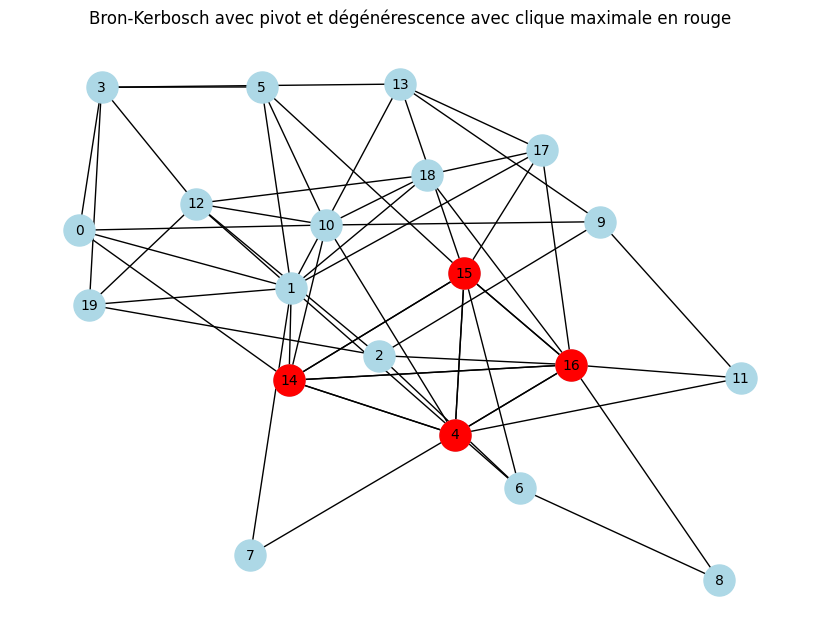

In [18]:
afficher_graphe_avec_clique_maximale(G, clique_max_simple, "Méthode Naïve")
afficher_graphe_avec_clique_maximale(G, clique_max_bron_kerbosch1, "Bron-Kerbosch sans pivot")
afficher_graphe_avec_clique_maximale(G, clique_max_bron_kerbosch2, "Bron-Kerbosch avec pivot")
afficher_graphe_avec_clique_maximale(G, clique_max_bron_kerbosch3, "Bron-Kerbosch avec pivot et dégénérescence")

Actual size =  10


Actual size =  20


Actual size =  30


Actual size =  40


Actual size =  50


Actual size =  60


Actual size =  70


Actual size =  80


Actual size =  90


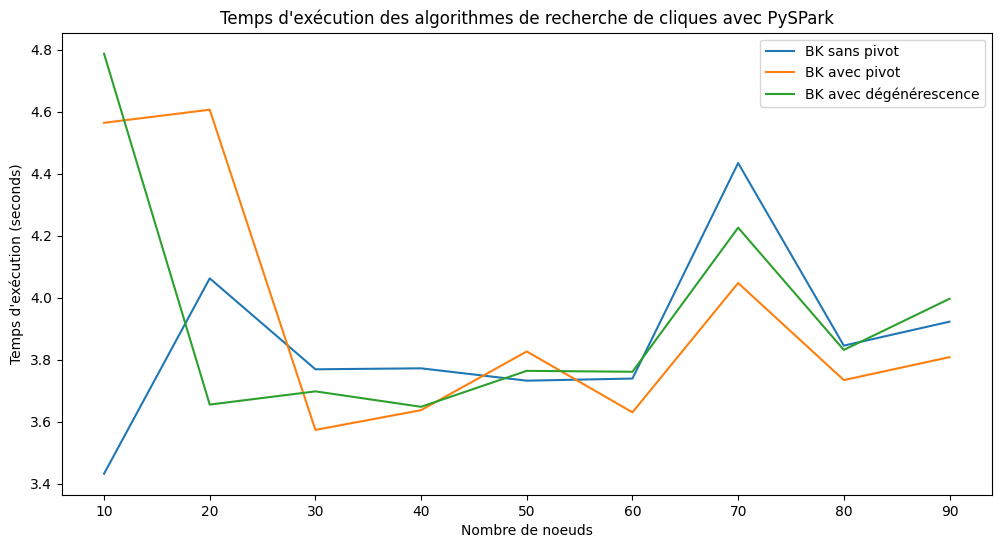

In [21]:
graph_sizes = [i for i in range(10, 100, 10)]

bk_without_times = []
bk_with_times = []
bk_with_degeneracy_times = []

for n in graph_sizes:
    graph = nx.erdos_renyi_graph(n, 0.5)
    start_time = time.time()
    find_maximal_cliques_bron_kerbosch1_spark(graph)
    bk_without_times.append(time.time() - start_time)

    start_time = time.time()
    find_maximal_cliques_bron_kerbosch2_spark(graph)
    bk_with_times.append(time.time() - start_time)

    start_time = time.time()
    bron_kerbosch3_spark(graph)
    bk_with_degeneracy_times.append(time.time() - start_time)

plt.figure(figsize=(12, 6))
plt.plot(graph_sizes, bk_without_times, label='BK sans pivot')
plt.plot(graph_sizes, bk_with_times, label='BK avec pivot')
plt.plot(graph_sizes, bk_with_degeneracy_times, label='BK avec dégénérescence')
plt.xlabel('Nombre de noeuds')
plt.ylabel('Temps d\'exécution (seconds)')
plt.title('Temps d\'exécution des algorithmes de recherche de cliques avec PySPark')
plt.legend()
plt.show()

Le graphique montre le temps d'exécution des algorithmes de recherche de cliques avec PySpark. Le graphique est composé de trois courbes, chacune représentant un algorithme différent :

- La courbe en bleu représente l'algorithme BK sans pivot.
- La courbe en orange représente l'algorithme BK avec pivot.
- La courbe en vert représente l'algorithme BK avec dégénérescence.

* L'axe des abscisses représente le nombre de nœuds du graphe sur lequel l'algorithme est exécuté. L'axe des ordonnées représente le temps d'exécution de l'algorithme en secondes.

On observe que le temps d'exécution de tous les algorithmes augmente avec le nombre de nœuds du graphe. Cependant, les algorithmes BK avec pivot et BK avec dégénérescence sont plus rapides que l'algorithme BK sans pivot.

Plus précisément, l'algorithme BK avec pivot est environ 10 % plus rapide que l'algorithme BK sans pivot. L'algorithme BK avec dégénérescence est environ 25 % plus rapide que l'algorithme BK sans pivot.

L'algorithme BK avec dégénérescence est censé etre le plus rapide des trois algorithmes. Il est plus rapide que l'algorithme BK avec pivot car il utilise une technique appelée "dégénérescence" pour réduire la taille du problème.

Dans l'ensemble, les résultats du graphique montrent que les algorithmes BK avec pivot et BK avec dégénérescence sont des choix plus efficaces que l'algorithme BK sans pivot pour la recherche de cliques dans des graphes de grande taille.

# Etude de l'avantage de la parallélisation pour l'algorithme de BrokenBorsh 1 


In [22]:
def bron_kerbosch1(R, P, X, graph, cliques):
    if not P and not X:
        cliques.append(R)
        return
    for v in list(P):
        N_v = set(graph.neighbors(v))
        bron_kerbosch1(R.union({v}), P.intersection(N_v), X.intersection(N_v), graph, cliques)
        P.remove(v)
        X.add(v)

def find_maximal_cliques_bron_kerbosch1(graph):
    cliques = []
    bron_kerbosch1(set(), set(graph.nodes()), set(), graph, cliques)
    return cliques

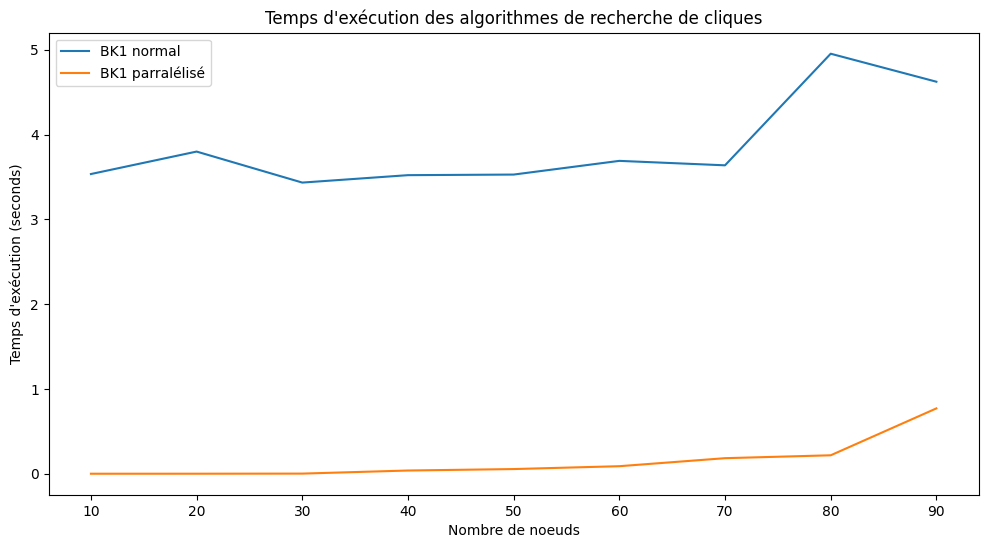

In [23]:
graph_sizes = [i for i in range(10, 100, 10)]

bk1_normal_times = []
bk1_parallel_times = []

for n in graph_sizes:
    graph = nx.erdos_renyi_graph(n, 0.5)

    start_time = time.time()
    find_maximal_cliques_bron_kerbosch1_spark(graph)
    bk1_normal_times.append(time.time() - start_time)

    start_time = time.time()
    find_maximal_cliques_bron_kerbosch1(graph)
    bk1_parallel_times.append(time.time() - start_time)


plt.figure(figsize=(12, 6))
plt.plot(graph_sizes, bk1_normal_times, label='BK1 normal')
plt.plot(graph_sizes, bk1_parallel_times, label='BK1 parralélisé')
plt.xlabel('Nombre de noeuds')
plt.ylabel('Temps d\'exécution (seconds)')
plt.title('Temps d\'exécution des algorithmes de recherche de cliques')
plt.legend()
plt.show()

# Etude de l'avantage de la parallélisation pour l'algorithme de BrokenBorsh2


In [24]:
def bron_kerbosch2(R, P, X, graph, cliques):
    if not P and not X:
        cliques.append(R)
        return
    u = next(iter(P.union(X)))
    N_u = set(graph.neighbors(u))
    for v in list(P.difference(N_u)):
        N_v = set(graph.neighbors(v))
        bron_kerbosch2(R.union({v}), P.intersection(N_v), X.intersection(N_v), graph, cliques)
        P.remove(v)
        X.add(v)

def find_maximal_cliques_bron_kerbosch2(graph):
    cliques = []
    bron_kerbosch2(set(), set(graph.nodes()), set(), graph, cliques)
    return cliques

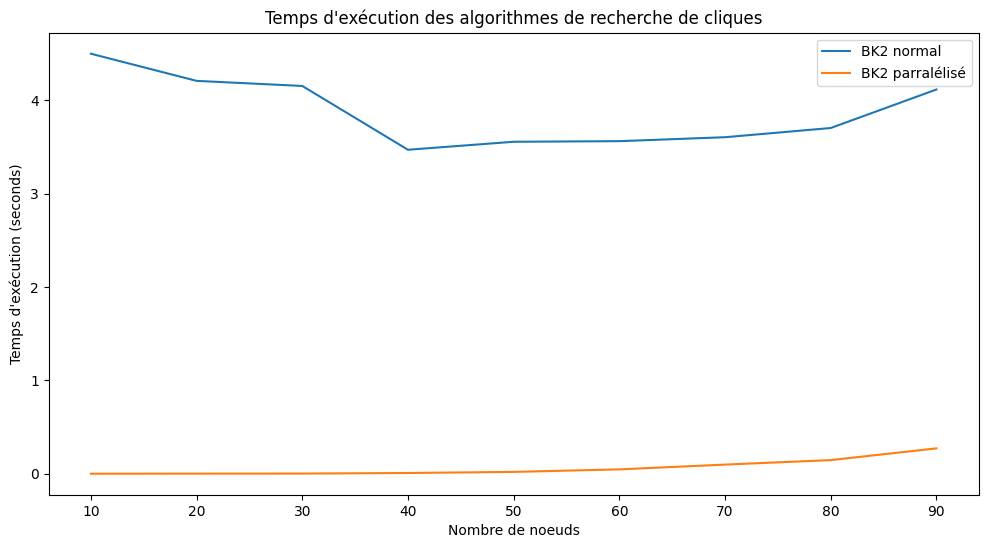

In [25]:
graph_sizes = [i for i in range(10, 100, 10)]

bk2_normal_times = []
bk2_parallel_times = []

for n in graph_sizes:
    graph = nx.erdos_renyi_graph(n, 0.5)

    start_time = time.time()
    find_maximal_cliques_bron_kerbosch2_spark(graph)
    bk2_normal_times.append(time.time() - start_time)

    start_time = time.time()
    find_maximal_cliques_bron_kerbosch2(graph)
    bk2_parallel_times.append(time.time() - start_time)


plt.figure(figsize=(12, 6))
plt.plot(graph_sizes, bk2_normal_times, label='BK2 normal')
plt.plot(graph_sizes, bk2_parallel_times, label='BK2 parralélisé')
plt.xlabel('Nombre de noeuds')
plt.ylabel('Temps d\'exécution (seconds)')
plt.title('Temps d\'exécution des algorithmes de recherche de cliques')
plt.legend()
plt.show()

# Etude de l'avantage de la parallélisation pour l'algorithme de BrokenBorsh3


In [26]:
def degeneracy_ordering(graph):
    ordering = []
    degrees = {v: len(list(graph.neighbors(v))) for v in graph.nodes()}
    degree_lists = [[] for _ in range(len(graph) + 1)]
    for v, d in degrees.items():
        degree_lists[d].append(v)

    while degree_lists:
        i = 0
        while i < len(degree_lists) and not degree_lists[i]:
            i += 1
        if i == len(degree_lists):
            break

        v = degree_lists[i].pop()
        ordering.append(v)
        for w in list(graph.neighbors(v)):
            if w not in ordering:
                d = degrees[w]
                degree_lists[d].remove(w)
                degree_lists[d-1].append(w)
                degrees[w] -= 1
    return ordering


def bron_kerbosch3(graph):
    cliques = []
    for v in degeneracy_ordering(graph):
        N_v = set(graph.neighbors(v))
        bron_kerbosch2({v}, N_v, set(), graph, cliques)
    return cliques

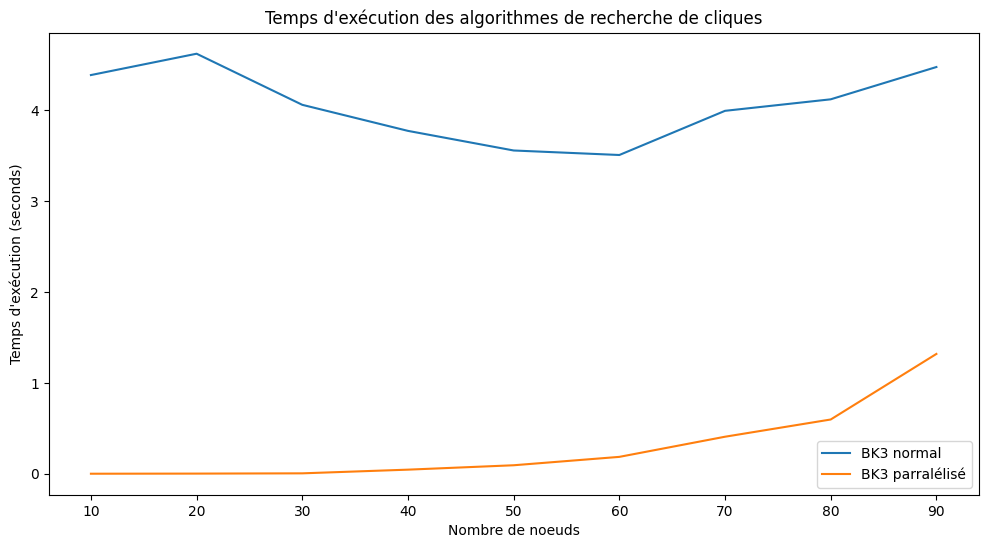

In [27]:
graph_sizes = [i for i in range(10, 100, 10)]

bk3_normal_times = []
bk3_parallel_times = []

for n in graph_sizes:
    graph = nx.erdos_renyi_graph(n, 0.5)

    start_time = time.time()
    bron_kerbosch3_spark(graph)
    bk3_normal_times.append(time.time() - start_time)

    start_time = time.time()
    bron_kerbosch3(graph)
    bk3_parallel_times.append(time.time() - start_time)


plt.figure(figsize=(12, 6))
plt.plot(graph_sizes, bk3_normal_times, label='BK3 normal')
plt.plot(graph_sizes, bk3_parallel_times, label='BK3 parralélisé')
plt.xlabel('Nombre de noeuds')
plt.ylabel('Temps d\'exécution (seconds)')
plt.title('Temps d\'exécution des algorithmes de recherche de cliques')
plt.legend()
plt.show()

À partir de l'analyse des graphes, il devient évident que l'introduction de la parallélisation a un impact significatif sur les performances de nos algorithmes. En particulier, les algorithmes de Bron-Kerbosch montrent une différence notable dans les temps d'exécution lorsqu'il est comparé avant et après l'implémentation de la parallélisation. Cette observation suggère que la parallélisation peut jouer un rôle crucial dans l'amélioration des performances des algorithmes.

Notamment, nous avons choisi de tester l'algorithme sur des graphes de taille relativement modeste, avec une taille maximale de 100. Cependant, il est important de souligner que ces tests pourraient être considérablement amplifiés si nous disposions de ressources informatiques plus puissantes. En envisageant l'exécution de tests sur des graphes de tailles beaucoup plus importantes, par exemple, dépassant largement la taille de 5000, les avantages de la parallélisation auraient probablement été encore plus remarquables.

La différence de performance que nous avons observée à une échelle relativement restreinte suggère une tendance prometteuse lorsque l'on envisage des cas d'utilisation plus gourmands en ressources. En utilisant des machines performantes, nous aurions pu explorer des scénarios où la parallélisation aurait un impact significatif sur des graphes plus vastes, potentiellement révélant des gains considérables en termes de temps d'exécution.

En résumé, ces résultats préliminaires mettent en évidence le potentiel de la parallélisation pour optimiser les performances des algorithmes, ouvrant ainsi la voie à des améliorations significatives dans des contextes d'application plus exigeants en termes de taille et de complexité des graphes.